In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
import xlnet
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import model_utils
import pickle
import json
pad_sequences = tf.compat.v1.keras.preprocessing.sequence.pad_sequences

In [3]:
import sentencepiece as spm
from prepro_utils import preprocess_text, encode_ids

sp_model = spm.SentencePieceProcessor()
sp_model.Load('xlnet-base-29-03-2020/sp10m.cased.v9.model')

def tokenize_fn(text):
    text = preprocess_text(text, lower= False)
    return encode_ids(sp_model, text)

In [4]:
SEG_ID_A   = 0
SEG_ID_B   = 1
SEG_ID_CLS = 2
SEG_ID_SEP = 3
SEG_ID_PAD = 4

special_symbols = {
    "<unk>"  : 0,
    "<s>"    : 1,
    "</s>"   : 2,
    "<cls>"  : 3,
    "<sep>"  : 4,
    "<pad>"  : 5,
    "<mask>" : 6,
    "<eod>"  : 7,
    "<eop>"  : 8,
}

VOCAB_SIZE = 32000
UNK_ID = special_symbols["<unk>"]
CLS_ID = special_symbols["<cls>"]
SEP_ID = special_symbols["<sep>"]
MASK_ID = special_symbols["<mask>"]
EOD_ID = special_symbols["<eod>"]

In [5]:
import pickle

with open('train_X.pkl', 'rb') as fopen:
    train_X, train_Y, train_depends, train_segments, train_masks = pickle.load(fopen)
    
with open('test_X.pkl', 'rb') as fopen:
    test_X, test_Y, test_depends, test_segments, test_masks = pickle.load(fopen)
    
with open('tags.pkl', 'rb') as fopen:
    idx2tag, tag2idx = pickle.load(fopen)

In [66]:
import xlnet
import model_utils
import tensorflow as tf
import numpy as np

kwargs = dict(
      is_training=True,
      use_tpu=False,
      use_bfloat16=False,
      dropout=0.1,
      dropatt=0.1,
      init='normal',
      init_range=0.1,
      init_std=0.05,
      clamp_len=-1)

xlnet_parameters = xlnet.RunConfig(**kwargs)
xlnet_config = xlnet.XLNetConfig(json_path='xlnet-base-29-03-2020/config.json')

In [7]:
epoch = 3
batch_size = 8
warmup_proportion = 0.1
num_train_steps = int(len(train_X) / batch_size * epoch)
num_warmup_steps = int(num_train_steps * warmup_proportion)
print(num_train_steps, num_warmup_steps)

training_parameters = dict(
      decay_method = 'poly',
      train_steps = num_train_steps,
      learning_rate = 2e-5,
      warmup_steps = num_warmup_steps,
      min_lr_ratio = 0.0,
      weight_decay = 0.00,
      adam_epsilon = 1e-8,
      num_core_per_host = 1,
      lr_layer_decay_rate = 1,
      use_tpu=False,
      use_bfloat16=False,
      dropout=0.0,
      dropatt=0.0,
      init='normal',
      init_range=0.1,
      init_std=0.02,
      clip = 1.0,
      clamp_len=-1,)

1173456 117345


In [8]:
class Parameter:
    def __init__(self, decay_method, warmup_steps, weight_decay, adam_epsilon, 
                num_core_per_host, lr_layer_decay_rate, use_tpu, learning_rate, train_steps,
                min_lr_ratio, clip, **kwargs):
        self.decay_method = decay_method
        self.warmup_steps = warmup_steps
        self.weight_decay = weight_decay
        self.adam_epsilon = adam_epsilon
        self.num_core_per_host = num_core_per_host
        self.lr_layer_decay_rate = lr_layer_decay_rate
        self.use_tpu = use_tpu
        self.learning_rate = learning_rate
        self.train_steps = train_steps
        self.min_lr_ratio = min_lr_ratio
        self.clip = clip
        
training_parameters = Parameter(**training_parameters)

In [9]:
class BiAAttention:
    def __init__(self, input_size_encoder, input_size_decoder, num_labels):
        self.input_size_encoder = input_size_encoder
        self.input_size_decoder = input_size_decoder
        self.num_labels = num_labels
        
        self.W_d = tf.compat.v1.get_variable("W_d", shape=[self.num_labels, self.input_size_decoder],
           initializer=tf.compat.v1.contrib.layers.xavier_initializer())
        self.W_e = tf.compat.v1.get_variable("W_e", shape=[self.num_labels, self.input_size_encoder],
           initializer=tf.compat.v1.contrib.layers.xavier_initializer())
        self.U = tf.compat.v1.get_variable("U", shape=[self.num_labels, self.input_size_decoder, self.input_size_encoder],
           initializer=tf.compat.v1.contrib.layers.xavier_initializer())
        
    def forward(self, input_d, input_e, mask_d=None, mask_e=None):
        batch = tf.compat.v1.shape(input_d)[0]
        length_decoder = tf.compat.v1.shape(input_d)[1]
        length_encoder = tf.compat.v1.shape(input_e)[1]
        out_d = tf.compat.v1.expand_dims(tf.compat.v1.matmul(self.W_d, tf.compat.v1.transpose(input_d, [0, 2, 1])), 3)
        out_e = tf.compat.v1.expand_dims(tf.compat.v1.matmul(self.W_e, tf.compat.v1.transpose(input_e, [0, 2, 1])), 2)
        output = tf.compat.v1.matmul(tf.compat.v1.expand_dims(input_d, 1), self.U)
        output = tf.compat.v1.matmul(output, tf.compat.v1.transpose(tf.compat.v1.expand_dims(input_e, 1), [0, 1, 3, 2]))
        
        output = output + out_d + out_e
        
        if mask_d is not None:
            d = tf.compat.v1.expand_dims(tf.compat.v1.expand_dims(mask_d, 1), 3)
            e = tf.compat.v1.expand_dims(tf.compat.v1.expand_dims(mask_e, 1), 2)
            output = output * d * e
            
        return output
    
class BiLinear:
    def __init__(self, left_features, right_features, out_features):
        self.left_features = left_features
        self.right_features = right_features
        self.out_features = out_features
        
        self.U = tf.compat.v1.get_variable("U-bi", shape=[out_features, left_features, right_features],
           initializer=tf.compat.v1.contrib.layers.xavier_initializer())
        self.W_l = tf.compat.v1.get_variable("Wl", shape=[out_features, left_features],
           initializer=tf.compat.v1.contrib.layers.xavier_initializer())
        self.W_r = tf.compat.v1.get_variable("Wr", shape=[out_features, right_features],
           initializer=tf.compat.v1.contrib.layers.xavier_initializer())
    
    def forward(self, input_left, input_right):
        left_size = tf.compat.v1.shape(input_left)
        output_shape = tf.compat.v1.concat([left_size[:-1], [self.out_features]], axis = 0)
        batch = tf.compat.v1.cast(tf.compat.v1.reduce_prod(left_size[:-1]), tf.compat.v1.int32)
        input_left = tf.compat.v1.reshape(input_left, (batch, self.left_features))
        input_right = tf.compat.v1.reshape(input_right, (batch, self.right_features))
        tiled = tf.compat.v1.tile(tf.compat.v1.expand_dims(input_left, axis = 0), (self.out_features,1,1))
        output = tf.compat.v1.transpose(tf.compat.v1.reduce_sum(tf.compat.v1.matmul(tiled, self.U), axis = 2))
        output = output + tf.compat.v1.matmul(input_left, tf.compat.v1.transpose(self.W_l))\
        + tf.compat.v1.matmul(input_right, tf.compat.v1.transpose(self.W_r))
        
        return tf.compat.v1.reshape(output, output_shape)


    
    def decode(self, input_word, input_char, mask, leading_symbolic=0):
        out_arc, out_type, _ = self.forward(input_word, input_char, mask)
        batch = tf.compat.v1.shape(out_arc)[0]
        max_len = tf.compat.v1.shape(out_arc)[1]
        sec_max_len = tf.compat.v1.shape(out_arc)[2]
        out_arc = out_arc + tf.compat.v1.linalg.diag(tf.compat.v1.fill([max_len], -np.inf))
        minus_mask = tf.compat.v1.expand_dims(tf.compat.v1.cast(1 - mask, tf.compat.v1.bool), axis = 2)
        minus_mask = tf.compat.v1.tile(minus_mask, [1, 1, sec_max_len])
        out_arc = tf.compat.v1.where(minus_mask, tf.compat.v1.fill(tf.compat.v1.shape(out_arc), -np.inf), out_arc)
        heads = tf.compat.v1.argmax(out_arc, axis = 1)
        type_h, type_c = out_type
        batch = tf.compat.v1.shape(type_h)[0]
        max_len = tf.compat.v1.shape(type_h)[1]
        batch_index = tf.compat.v1.range(0, batch)
        t = tf.compat.v1.cast(tf.compat.v1.transpose(heads), tf.compat.v1.int32)
        broadcasted = tf.compat.v1.broadcast_to(batch_index, tf.compat.v1.shape(t))
        concatenated = tf.compat.v1.transpose(tf.compat.v1.concat([tf.compat.v1.expand_dims(broadcasted, axis = 0), 
                                               tf.compat.v1.expand_dims(t, axis = 0)], axis = 0))
        type_h = tf.compat.v1.gather_nd(type_h, concatenated)
        out_type = self.bilinear.forward(type_h, type_c)
        out_type = out_type[:, :, leading_symbolic:]
        types = tf.compat.v1.argmax(out_type, axis = 2)
        return heads, types
    
class Model:
    def __init__(
        self,
        learning_rate,
        hidden_size_word,
        cov = 0.0):
        
        self.words = @@#placeholder(tf.compat.v1.int32, (None, None))
        self.segment_ids = @@#placeholder(tf.compat.v1.int32, [None, None])
        self.input_masks = @@#placeholder(tf.compat.v1.float32, [None, None])
        self.heads = @@#placeholder(tf.compat.v1.int32, (None, None))
        self.types = @@#placeholder(tf.compat.v1.int32, (None, None))
        self.switch = @@#placeholder(tf.compat.v1.bool, None)
        self.mask = tf.compat.v1.cast(tf.compat.v1.math.not_equal(self.words, 0), tf.compat.v1.float32)
        self.maxlen = tf.compat.v1.shape(self.words)[1]
        self.lengths = tf.compat.v1.count_nonzero(self.words, 1)
        mask = self.mask
        heads = self.heads
        types = self.types
        
        self.arc_h = tf.compat.v1.layers.Dense(hidden_size_word)
        self.arc_c = tf.compat.v1.layers.Dense(hidden_size_word)
        self.attention = BiAAttention(hidden_size_word, hidden_size_word, 1)

        self.type_h = tf.compat.v1.layers.Dense(hidden_size_word)
        self.type_c = tf.compat.v1.layers.Dense(hidden_size_word)
        self.bilinear = BiLinear(hidden_size_word, hidden_size_word, len(tag2idx))
        
        xlnet_model = xlnet.XLNetModel(
            xlnet_config=xlnet_config,
            run_config=xlnet_parameters,
            input_ids=tf.compat.v1.transpose(self.words, [1, 0]),
            seg_ids=tf.compat.v1.transpose(self.segment_ids, [1, 0]),
            input_mask=tf.compat.v1.transpose(self.input_masks, [1, 0]))
        output_layer = xlnet_model.get_sequence_output()
        output_layer = tf.compat.v1.transpose(output_layer, [1, 0, 2])
        
        arc_h = tf.compat.v1.nn.elu(self.arc_h(output_layer))
        arc_c = tf.compat.v1.nn.elu(self.arc_c(output_layer))
        
        type_h = tf.compat.v1.nn.elu(self.type_h(output_layer))
        type_c = tf.compat.v1.nn.elu(self.type_c(output_layer))
        
        out_arc = tf.compat.v1.squeeze(self.attention.forward(arc_h, arc_c, mask_d=self.mask, 
                                                    mask_e=self.mask), axis = 1)
        
        batch = tf.compat.v1.shape(out_arc)[0]
        max_len = tf.compat.v1.shape(out_arc)[1]
        sec_max_len = tf.compat.v1.shape(out_arc)[2]
        batch_index = tf.compat.v1.range(0, batch)
        
        decode_arc = out_arc + tf.compat.v1.linalg.diag(tf.compat.v1.fill([max_len], -np.inf))
        minus_mask = tf.compat.v1.expand_dims(tf.compat.v1.cast(1 - mask, tf.compat.v1.bool), axis = 2)
        minus_mask = tf.compat.v1.tile(minus_mask, [1, 1, sec_max_len])
        decode_arc = tf.compat.v1.where(minus_mask, tf.compat.v1.fill(tf.compat.v1.shape(decode_arc), -np.inf), decode_arc)
        self.heads_seq = tf.compat.v1.argmax(decode_arc, axis = 1)
        self.heads_seq = tf.compat.v1.identity(self.heads_seq, name = 'heads_seq')
        
        t = tf.compat.v1.cast(tf.compat.v1.transpose(self.heads_seq), tf.compat.v1.int32)
        broadcasted = tf.compat.v1.broadcast_to(batch_index, tf.compat.v1.shape(t))
        concatenated = tf.compat.v1.transpose(tf.compat.v1.concat([tf.compat.v1.expand_dims(broadcasted, axis = 0), 
                                               tf.compat.v1.expand_dims(t, axis = 0)], axis = 0))
        type_h = tf.compat.v1.gather_nd(type_h, concatenated)
        out_type = self.bilinear.forward(type_h, type_c)
        self.tags_seq = tf.compat.v1.argmax(out_type, axis = 2)
        self.tags_seq = tf.compat.v1.identity(self.tags_seq, name = 'tags_seq')
        
        log_likelihood, transition_params = tf.compat.v1.contrib.crf.crf_log_likelihood(
            out_type, self.types, self.lengths
        )
        crf_loss = tf.compat.v1.reduce_mean(-log_likelihood)
        self.logits, _ = tf.compat.v1.contrib.crf.crf_decode(
            out_type, transition_params, self.lengths
        )
        self.logits = tf.compat.v1.identity(self.logits, name = 'logits')
        
        batch = tf.compat.v1.shape(out_arc)[0]
        max_len = tf.compat.v1.shape(out_arc)[1]
        batch_index = tf.compat.v1.range(0, batch)
        t = tf.compat.v1.transpose(heads)
        broadcasted = tf.compat.v1.broadcast_to(batch_index, tf.compat.v1.shape(t))
        concatenated = tf.compat.v1.transpose(tf.compat.v1.concat([tf.compat.v1.expand_dims(broadcasted, axis = 0), 
                                               tf.compat.v1.expand_dims(t, axis = 0)], axis = 0))
        type_h = tf.compat.v1.gather_nd(type_h, concatenated)
        out_type = self.bilinear.forward(type_h, type_c)
        minus_inf = -1e8
        minus_mask = (1 - mask) * minus_inf
        out_arc = out_arc + tf.compat.v1.expand_dims(minus_mask, axis = 2) + tf.compat.v1.expand_dims(minus_mask, axis = 1)
        loss_arc = tf.compat.v1.nn.log_softmax(out_arc, dim=1)
        loss_type = tf.compat.v1.nn.log_softmax(out_type, dim=2)
        loss_arc = loss_arc * tf.compat.v1.expand_dims(mask, axis = 2) * tf.compat.v1.expand_dims(mask, axis = 1)
        loss_type = loss_type * tf.compat.v1.expand_dims(mask, axis = 2)
        num = tf.compat.v1.reduce_sum(mask) - tf.compat.v1.cast(batch, tf.compat.v1.float32)
        child_index = tf.compat.v1.tile(tf.compat.v1.expand_dims(tf.compat.v1.range(0, max_len), 1), [1, batch])
        t = tf.compat.v1.transpose(heads)
        broadcasted = tf.compat.v1.broadcast_to(batch_index, tf.compat.v1.shape(t))
        concatenated = tf.compat.v1.transpose(tf.compat.v1.concat([tf.compat.v1.expand_dims(broadcasted, axis = 0),
                                               tf.compat.v1.expand_dims(t, axis = 0),
                                               tf.compat.v1.expand_dims(child_index, axis = 0)], axis = 0))
        loss_arc = tf.compat.v1.gather_nd(loss_arc, concatenated)
        loss_arc = tf.compat.v1.transpose(loss_arc, [1, 0])
        
        t = tf.compat.v1.transpose(types)
        broadcasted = tf.compat.v1.broadcast_to(batch_index, tf.compat.v1.shape(t))
        concatenated = tf.compat.v1.transpose(tf.compat.v1.concat([tf.compat.v1.expand_dims(broadcasted, axis = 0),
                                               tf.compat.v1.expand_dims(child_index, axis = 0),
                                               tf.compat.v1.expand_dims(t, axis = 0)], axis = 0))
        loss_type = tf.compat.v1.gather_nd(loss_type, concatenated)
        loss_type = tf.compat.v1.transpose(loss_type, [1, 0])
        cost = (tf.compat.v1.reduce_sum(-loss_arc) / num) + (tf.compat.v1.reduce_sum(-loss_type) / num)
        
        self.cost = tf.compat.v1.cond(self.switch, lambda: cost + crf_loss, lambda: cost)
        self.optimizer = tf.compat.v1.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        
        mask = tf.compat.v1.sequence_mask(self.lengths, maxlen = self.maxlen)
        
        self.prediction = tf.compat.v1.boolean_mask(self.logits, mask)
        mask_label = tf.compat.v1.boolean_mask(self.types, mask)
        correct_pred = tf.compat.v1.equal(tf.compat.v1.cast(self.prediction, tf.compat.v1.int32), mask_label)
        correct_index = tf.compat.v1.cast(correct_pred, tf.compat.v1.float32)
        self.accuracy = tf.compat.v1.reduce_mean(tf.compat.v1.cast(correct_pred, tf.compat.v1.float32))
        
        self.prediction = tf.compat.v1.cast(tf.compat.v1.boolean_mask(self.heads_seq, mask), tf.compat.v1.int32)
        mask_label = tf.compat.v1.boolean_mask(self.heads, mask)
        correct_pred = tf.compat.v1.equal(self.prediction, mask_label)
        correct_index = tf.compat.v1.cast(correct_pred, tf.compat.v1.float32)
        self.accuracy_depends = tf.compat.v1.reduce_mean(tf.compat.v1.cast(correct_pred, tf.compat.v1.float32))

In [67]:
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()

learning_rate = 2e-5
hidden_size_word = 256

model = Model(learning_rate, hidden_size_word)
sess.run(tf.compat.v1.global_variables_initializer())

INFO:tensorflow:memory input None
INFO:tensorflow:Use float type <dtype: 'float32'>


In [11]:
import collections
import re

def get_assignment_map_from_checkpoint(tvars, init_checkpoint):
    """Compute the union of the current variables and checkpoint variables."""
    assignment_map = {}
    initialized_variable_names = {}

    name_to_variable = collections.OrderedDict()
    for var in tvars:
        name = var.name
        m = re.match('^(.*):\\d+$', name)
        if m is not None:
            name = m.group(1)
        name_to_variable[name] = var

    init_vars = tf.compat.v1.train.list_variables(init_checkpoint)

    assignment_map = collections.OrderedDict()
    for x in init_vars:
        (name, var) = (x[0], x[1])
        if name not in name_to_variable:
            continue
        assignment_map[name] = name_to_variable[name]
        initialized_variable_names[name] = 1
        initialized_variable_names[name + ':0'] = 1

    return (assignment_map, initialized_variable_names)

In [12]:
tvars = tf.compat.v1.trainable_variables()
checkpoint = 'xlnet-base-29-03-2020/model.ckpt-300000'
assignment_map, initialized_variable_names = get_assignment_map_from_checkpoint(tvars, 
                                                                                checkpoint)

In [13]:
saver = tf.compat.v1.train.Saver(var_list = assignment_map)
saver.restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from xlnet-base-29-03-2020/model.ckpt-300000


In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

batch_x = train_X[:5]
batch_x = pad_sequences(batch_x,padding='post')
batch_y = train_Y[:5]
batch_y = pad_sequences(batch_y,padding='post')
batch_depends = train_depends[:5]
batch_depends = pad_sequences(batch_depends,padding='post')
batch_segments = train_segments[:5]
batch_segments = pad_sequences(batch_segments, padding='post', value = 4)
batch_masks = train_masks[:5]
batch_masks = pad_sequences(batch_masks, padding='post', value = 1)

In [15]:
sess.run([model.accuracy, model.accuracy_depends, model.cost],
        feed_dict = {model.words: batch_x,
                model.types: batch_y,
                model.heads: batch_depends,
                model.segment_ids: batch_segments,
                model.input_masks: batch_masks,
                model.switch: False})

[0.03529412, 0.07058824, 140.91621]

In [16]:
sess.run([model.accuracy, model.accuracy_depends, model.cost],
        feed_dict = {model.words: batch_x,
                model.types: batch_y,
                model.heads: batch_depends,
                model.segment_ids: batch_segments,
                model.input_masks: batch_masks,
                model.switch: True})

[0.047058824, 0.023529412, 352.61438]

In [48]:
from tqdm import tqdm

epoch = 1
for e in range(epoch):
    train_acc, train_loss = [], []
    test_acc, test_loss = [], []
    train_acc_depends, test_acc_depends = [], []
    
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(train_X))
        batch_x = train_X[i: index]
        batch_x = pad_sequences(batch_x,padding='post')
        batch_y = train_Y[i: index]
        batch_y = pad_sequences(batch_y,padding='post')
        batch_depends = train_depends[i: index]
        batch_depends = pad_sequences(batch_depends,padding='post')
        batch_segments = train_segments[i: index]
        batch_segments = pad_sequences(batch_segments, padding='post', value = 4)
        batch_masks = train_masks[i: index]
        batch_masks = pad_sequences(batch_masks, padding='post', value = 1)
        
        if batch_x.shape == batch_y.shape:
        
            acc_depends, acc, cost, _ = sess.run(
                [model.accuracy_depends, model.accuracy, model.cost, model.optimizer],
                feed_dict = {
                    model.words: batch_x,
                    model.types: batch_y,
                    model.heads: batch_depends,
                    model.segment_ids: batch_segments,
                    model.input_masks: batch_masks,
                    model.switch: False
                },
            )
            train_loss.append(cost)
            train_acc.append(acc)
            train_acc_depends.append(acc_depends)
            pbar.set_postfix(cost = cost, accuracy = acc, accuracy_depends = acc_depends)
        
    pbar = tqdm(
        range(0, len(test_X), batch_size), desc = 'test minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(test_X))
        batch_x = test_X[i: index]
        batch_x = pad_sequences(batch_x,padding='post')
        batch_y = test_Y[i: index]
        batch_y = pad_sequences(batch_y,padding='post')
        batch_depends = test_depends[i: index]
        batch_depends = pad_sequences(batch_depends,padding='post')
        batch_segments = test_segments[i: index]
        batch_segments = pad_sequences(batch_segments, padding='post', value = 4)
        batch_masks = test_masks[i: index]
        batch_masks = pad_sequences(batch_masks, padding='post', value = 1)
        
        if batch_x.shape == batch_y.shape:
        
            acc_depends, acc, cost = sess.run(
                [model.accuracy_depends, model.accuracy, model.cost],
                feed_dict = {
                    model.words: batch_x,
                    model.types: batch_y,
                    model.heads: batch_depends,
                    model.segment_ids: batch_segments,
                    model.input_masks: batch_masks,
                    model.switch: False
                },
            )
            test_loss.append(cost)
            test_acc.append(acc)
            test_acc_depends.append(acc_depends)
            pbar.set_postfix(cost = cost, accuracy = acc, accuracy_depends = acc_depends)
    
    
    print(
    'epoch: %d, training loss: %f, training acc: %f, training depends: %f, valid loss: %f, valid acc: %f, valid depends: %f\n'
    % (e, np.mean(train_loss), 
       np.mean(train_acc), 
       np.mean(train_acc_depends), 
       np.mean(test_loss), 
       np.mean(test_acc), 
       np.mean(test_acc_depends)
    ))
    
    saver = tf.compat.v1.train.Saver(tf.compat.v1.trainable_variables())
    saver.save(sess, 'xlnet-base-dependency/model.ckpt')

test minibatch loop: 100%|██████████| 1250/1250 [02:16<00:00,  9.19it/s, accuracy=0.945, accuracy_depends=0.853, cost=0.234] 


epoch: 0, training loss: 0.401834, training acc: 0.901875, training depends: 0.845306, valid loss: 0.386272, valid acc: 0.902461, valid depends: 0.848041



In [69]:
from tqdm import tqdm

epoch = 1
for e in range(epoch):
    train_acc, train_loss = [], []
    test_acc, test_loss = [], []
    train_acc_depends, test_acc_depends = [], []
    
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(train_X))
        batch_x = train_X[i: index]
        batch_x = pad_sequences(batch_x,padding='post')
        batch_y = train_Y[i: index]
        batch_y = pad_sequences(batch_y,padding='post')
        batch_depends = train_depends[i: index]
        batch_depends = pad_sequences(batch_depends,padding='post')
        batch_segments = train_segments[i: index]
        batch_segments = pad_sequences(batch_segments, padding='post', value = 4)
        batch_masks = train_masks[i: index]
        batch_masks = pad_sequences(batch_masks, padding='post', value = 1)
        
        if batch_x.shape == batch_y.shape:
        
            acc_depends, acc, cost, _ = sess.run(
                [model.accuracy_depends, model.accuracy, model.cost, model.optimizer],
                feed_dict = {
                    model.words: batch_x,
                    model.types: batch_y,
                    model.heads: batch_depends,
                    model.segment_ids: batch_segments,
                    model.input_masks: batch_masks,
                    model.switch: True
                },
            )
            train_loss.append(cost)
            train_acc.append(acc)
            train_acc_depends.append(acc_depends)
            pbar.set_postfix(cost = cost, accuracy = acc, accuracy_depends = acc_depends)
        
    pbar = tqdm(
        range(0, len(test_X), batch_size), desc = 'test minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(test_X))
        batch_x = test_X[i: index]
        batch_x = pad_sequences(batch_x,padding='post')
        batch_y = test_Y[i: index]
        batch_y = pad_sequences(batch_y,padding='post')
        batch_depends = test_depends[i: index]
        batch_depends = pad_sequences(batch_depends,padding='post')
        batch_segments = test_segments[i: index]
        batch_segments = pad_sequences(batch_segments, padding='post', value = 4)
        batch_masks = test_masks[i: index]
        batch_masks = pad_sequences(batch_masks, padding='post', value = 1)
        
        if batch_x.shape == batch_y.shape:
        
            acc_depends, acc, cost = sess.run(
                [model.accuracy_depends, model.accuracy, model.cost],
                feed_dict = {
                    model.words: batch_x,
                    model.types: batch_y,
                    model.heads: batch_depends,
                    model.segment_ids: batch_segments,
                    model.input_masks: batch_masks,
                    model.switch: True
                },
            )
            test_loss.append(cost)
            test_acc.append(acc)
            test_acc_depends.append(acc_depends)
            pbar.set_postfix(cost = cost, accuracy = acc, accuracy_depends = acc_depends)
    
    
    print(
    'epoch: %d, training loss: %f, training acc: %f, training depends: %f, valid loss: %f, valid acc: %f, valid depends: %f\n'
    % (e, np.mean(train_loss), 
       np.mean(train_acc), 
       np.mean(train_acc_depends), 
       np.mean(test_loss), 
       np.mean(test_acc), 
       np.mean(test_acc_depends)
    ))
    
    saver = tf.compat.v1.train.Saver(tf.compat.v1.trainable_variables())
    saver.save(sess, 'xlnet-base-dependency/model.ckpt')

test minibatch loop: 100%|██████████| 1250/1250 [02:17<00:00,  9.12it/s, accuracy=0.969, accuracy_depends=0.859, cost=1.82] 


epoch: 0, training loss: 3.694703, training acc: 0.950186, training depends: 0.846899, valid loss: 3.673369, valid acc: 0.951140, valid depends: 0.844435



In [49]:
batch_x.shape, batch_y.shape

((8, 52), (8, 52))

In [50]:
def merge_sentencepiece_tokens_tagging(x, y):
    new_paired_tokens = []
    n_tokens = len(x)
    rejected = ['<cls>', '<sep>']

    i = 0

    while i < n_tokens:

        current_token, current_label = x[i], y[i]
        if not current_token.startswith('▁') and current_token not in rejected:
            previous_token, previous_label = new_paired_tokens.pop()
            merged_token = previous_token
            merged_label = [previous_label]
            while (
                not current_token.startswith('▁')
                and current_token not in rejected
            ):
                merged_token = merged_token + current_token.replace('▁', '')
                merged_label.append(current_label)
                i = i + 1
                current_token, current_label = x[i], y[i]
            merged_label = merged_label[0]
            new_paired_tokens.append((merged_token, merged_label))

        else:
            new_paired_tokens.append((current_token, current_label))
            i = i + 1

    words = [
        i[0].replace('▁', '')
        for i in new_paired_tokens
        if i[0] not in ['<cls>', '<sep>']
    ]
    labels = [i[1] for i in new_paired_tokens if i[0] not in ['<cls>', '<sep>']]
    return words, labels

In [51]:
import re
from unidecode import unidecode
from malaya.function.parse_dependency import DependencyGraph

PUNCTUATION = '!"#$%&\'()*+,./:;<=>?@[\]^_`{|}~'

def transformer_textcleaning(string):
    """
    use by any transformer model before tokenization
    """
    string = unidecode(string)
    string = re.sub('\\(dot\\)', '.', string)
    string = (
        re.sub(re.findall(r'\<a(.*?)\>', string)[0], '', string)
        if (len(re.findall(r'\<a (.*?)\>', string)) > 0)
        and ('href' in re.findall(r'\<a (.*?)\>', string)[0])
        else string
    )
    string = re.sub(
        r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', string
    )
    string = re.sub(r'[ ]+', ' ', string).strip().split()
    string = [w for w in string if w[0] != '@']
    string = ' '.join(string)
    string = re.sub(f'([{PUNCTUATION}])', r' \1 ', string)
    string = re.sub('\s{2,}', ' ', string)
    original_string = string.split()
    string = [
        (original_string[no], word.title() if word.isupper() else word)
        for no, word in enumerate(string.split())
        if len(word)
    ]
    return [s[0] for s in string], [s[1] for s in string]

def parse_X(left):
    left = ' '.join(left)
    bert_tokens = tokenize_fn(left)
    bert_tokens.extend([3, 4])
    segment = [0] * (len(bert_tokens) - 1) + [SEG_ID_CLS]
    input_mask = [0] * len(segment)
    s_tokens = [sp_model.IdToPiece(i) for i in bert_tokens]
    return bert_tokens, segment, input_mask, s_tokens

In [52]:
def dependency_graph(tagging, indexing):
    """
    Return helper object for dependency parser results. Only accept tagging and indexing outputs from dependency models.
    """
    result = []
    for i in range(len(tagging)):
        result.append(
            '%d\t%s\t_\t_\t_\t_\t%d\t%s\t_\t_'
            % (i + 1, tagging[i][0], int(indexing[i][1]), tagging[i][1])
        )
    return DependencyGraph('\n'.join(result), top_relation_label='root')

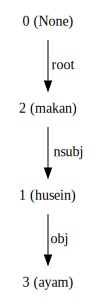

In [70]:
string = 'husein makan ayam'
sequence = transformer_textcleaning(string)[1]
parsed_sequence, segment_sequence, mask_sequence, xlnet_sequence = parse_X(sequence)
h, t = sess.run([model.heads_seq, model.tags_seq],
        feed_dict = {
            model.words: [parsed_sequence],
            model.segment_ids: [segment_sequence],
            model.input_masks: [mask_sequence],
        },
)
h = h[0] - 2
t = [idx2tag[d] for d in t[0]]
merged_h = merge_sentencepiece_tokens_tagging(xlnet_sequence, h)
merged_t = merge_sentencepiece_tokens_tagging(xlnet_sequence, t)
tagging = list(zip(merged_t[0], merged_t[1]))
indexing = list(zip(merged_h[0], merged_h[1]))
dep = dependency_graph(tagging, indexing)
dep.to_graphvis()

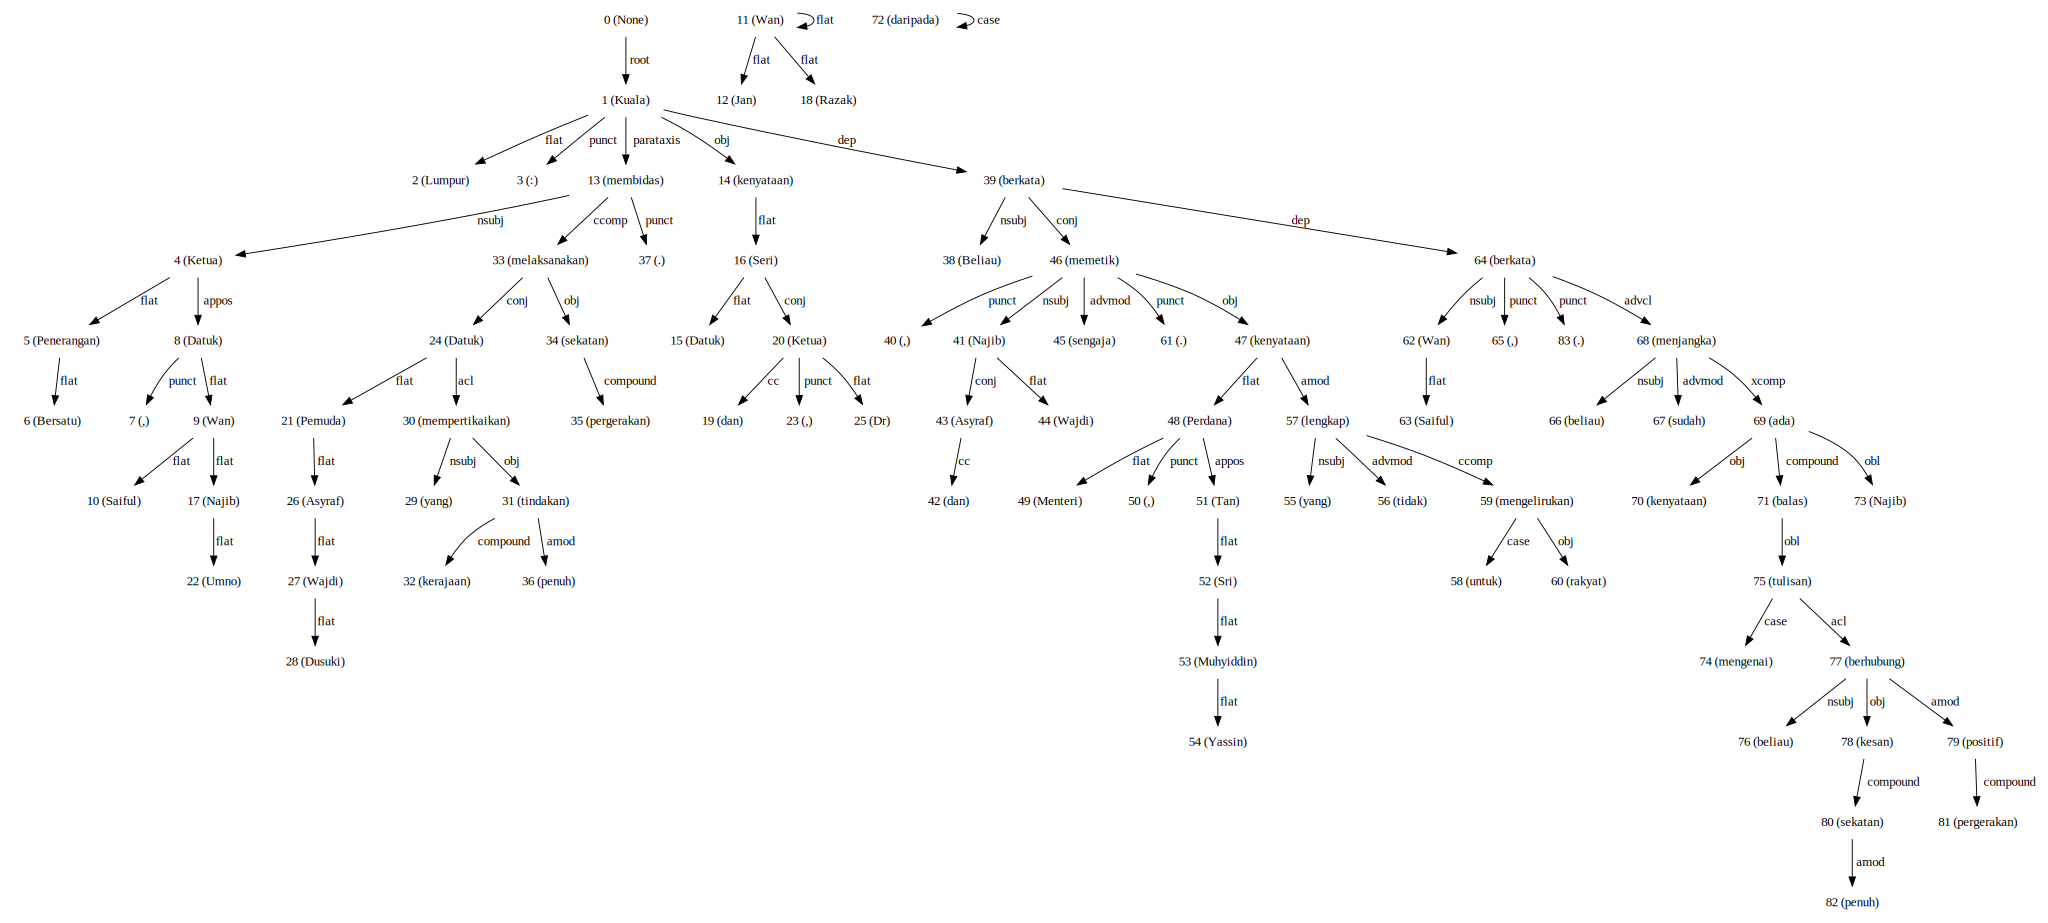

In [71]:
string = 'KUALA LUMPUR: Ketua Penerangan BERSATU, Datuk Wan Saiful Wan Jan membidas kenyataan Datuk Seri Najib Razak dan Ketua Pemuda UMNO, Datuk Dr Asyraf Wajdi Dusuki yang mempertikaikan tindakan kerajaan melaksanakan sekatan pergerakan penuh. Beliau berkata, Najib dan Asyraf Wajdi sengaja memetik kenyataan Perdana Menteri, Tan Sri Muhyiddin Yassin yang tidak lengkap untuk mengelirukan rakyat. Wan Saiful berkata, beliau sudah menjangka ada kenyataan balas daripada Najib mengenai tulisan beliau berhubung kesan positif sekatan pergerakan penuh.'
sequence = transformer_textcleaning(string)[1]
parsed_sequence, segment_sequence, mask_sequence, xlnet_sequence = parse_X(sequence)
h, t = sess.run([model.heads_seq, model.tags_seq],
        feed_dict = {
            model.words: [parsed_sequence],
            model.segment_ids: [segment_sequence],
            model.input_masks: [mask_sequence],
        },
)
h = h[0] - 2
t = [idx2tag[d] for d in t[0]]
merged_h = merge_sentencepiece_tokens_tagging(xlnet_sequence, h)
merged_t = merge_sentencepiece_tokens_tagging(xlnet_sequence, t)
tagging = list(zip(merged_t[0], merged_t[1]))
indexing = list(zip(merged_h[0], merged_h[1]))
dep = dependency_graph(tagging, indexing)
dep.to_graphvis()

In [72]:
saver = tf.compat.v1.train.Saver(tf.compat.v1.trainable_variables())
saver.save(sess, 'xlnet-base-dependency/model.ckpt')

'xlnet-base-dependency/model.ckpt'

In [73]:
kwargs = dict(
      is_training=False,
      use_tpu=False,
      use_bfloat16=False,
      dropout=0.0,
      dropatt=0.0,
      init='normal',
      init_range=0.1,
      init_std=0.05,
      clamp_len=-1)

xlnet_parameters = xlnet.RunConfig(**kwargs)
xlnet_config = xlnet.XLNetConfig(json_path='xlnet-base-29-03-2020/config.json')

In [74]:
learning_rate = 2e-5
hidden_size_word = 256

tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()
model = Model(learning_rate, hidden_size_word)
sess.run(tf.compat.v1.global_variables_initializer())

INFO:tensorflow:memory input None
INFO:tensorflow:Use float type <dtype: 'float32'>


In [75]:
saver = tf.compat.v1.train.Saver(tf.compat.v1.trainable_variables())
saver.restore(sess, 'xlnet-base-dependency/model.ckpt')

INFO:tensorflow:Restoring parameters from xlnet-base-dependency/model.ckpt


In [76]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p])
        out.append(out_i)
    return out

In [77]:
def evaluate(heads_pred, types_pred, heads, types, lengths,
             symbolic_root=False, symbolic_end=False):
    batch_size, _ = heads_pred.shape
    ucorr = 0.
    lcorr = 0.
    total = 0.
    ucomplete_match = 0.
    lcomplete_match = 0.

    corr_root = 0.
    total_root = 0.
    start = 1 if symbolic_root else 0
    end = 1 if symbolic_end else 0
    for i in range(batch_size):
        ucm = 1.
        lcm = 1.
        for j in range(start, lengths[i] - end):

            total += 1
            if heads[i, j] == heads_pred[i, j]:
                ucorr += 1
                if types[i, j] == types_pred[i, j]:
                    lcorr += 1
                else:
                    lcm = 0
            else:
                ucm = 0
                lcm = 0

            if heads[i, j] == 0:
                total_root += 1
                corr_root += 1 if heads_pred[i, j] == 0 else 0

        ucomplete_match += ucm
        lcomplete_match += lcm
    
    return ucorr / total, lcorr / total, corr_root / total_root

In [78]:
arcs, types, roots = [], [], []
real_Y, predict_Y = [], []

for i in tqdm(range(0, len(test_X), batch_size)):
    index = min(i + batch_size, len(test_X))
    batch_x = test_X[i: index]
    batch_x = pad_sequences(batch_x,padding='post')
    batch_y = test_Y[i: index]
    batch_y = pad_sequences(batch_y,padding='post')
    batch_depends = test_depends[i: index]
    batch_depends = pad_sequences(batch_depends,padding='post')
    batch_segments = test_segments[i: index]
    batch_segments = pad_sequences(batch_segments, padding='post', value = 4)
    batch_masks = test_masks[i: index]
    batch_masks = pad_sequences(batch_masks, padding='post', value = 1)
    
    tags_seq, heads = sess.run(
        [model.logits, model.heads_seq],
        feed_dict = {
            model.words: batch_x,
            model.segment_ids: batch_segments,
            model.input_masks: batch_masks
        },
    )
    
    arc_accuracy, type_accuracy, root_accuracy = evaluate(heads - 1, tags_seq, batch_depends - 1, batch_y, 
            np.count_nonzero(batch_x, axis = 1))
    arcs.append(arc_accuracy)
    types.append(type_accuracy)
    roots.append(root_accuracy)
    predicted = pred2label(tags_seq)
    real = pred2label(batch_y)
    predict_Y.extend(predicted)
    real_Y.extend(real)

100%|██████████| 1250/1250 [02:03<00:00, 10.15it/s]


In [79]:
temp_real_Y = []
for r in real_Y:
    temp_real_Y.extend(r)
    
temp_predict_Y = []
for r in predict_Y:
    temp_predict_Y.extend(r)


In [80]:
from sklearn.metrics import classification_report
print(classification_report(temp_real_Y, temp_predict_Y, digits = 5))

               precision    recall  f1-score   support

          PAD    0.99976   1.00000   0.99988    339805
            X    1.00000   0.99938   0.99969     62631
          acl    0.84425   0.83292   0.83855      3202
        advcl    0.64532   0.68824   0.66609      1684
       advmod    0.95594   0.94239   0.94912      6700
         amod    0.90791   0.90995   0.90893      4464
        appos    0.84555   0.77299   0.80765      3088
         case    0.98213   0.98372   0.98292     11117
           cc    0.97966   0.97993   0.97979      3637
        ccomp    0.48588   0.48315   0.48451       356
     compound    0.91807   0.92646   0.92224     11381
compound:plur    0.51163   0.66667   0.57895        33
         conj    0.90245   0.89455   0.89849      5140
          cop    0.97639   0.97639   0.97639       593
        csubj    0.33333   0.16667   0.22222         6
   csubj:pass    0.00000   0.00000   0.00000         1
          dep    0.66500   0.73684   0.69908       361
         

In [82]:
print('arc accuracy:', np.mean(arcs))
print('types accuracy:', np.mean(types))
print('root accuracy:', np.mean(roots))

arc accuracy: 0.8481110435316473
types accuracy: 0.8274148274750857
root accuracy: 0.9210116457364005


In [83]:
strings = ','.join(
    [
        n.name
        for n in tf.compat.v1.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or '_seq' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name
        or 'self/Softmax' in n.name)
        and 'Adam' not in n.name
        and 'beta' not in n.name
        and 'global_step' not in n.name
        and 'adam' not in n.name
        and 'gradients/bert' not in n.name
    ]
)

In [84]:
def freeze_graph(model_dir, output_node_names):

    if not tf.compat.v1.io.gfile.exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.compat.v1.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.compat.v1.Session(graph = tf.compat.v1.Graph()) as sess:
        saver = tf.compat.v1.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.compat.v1.graph_util.convert_variables_to_constants(
            sess,
            tf.compat.v1.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.compat.v1.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [85]:
freeze_graph('xlnet-base-dependency', strings)

INFO:tensorflow:Restoring parameters from xlnet-base-dependency/model.ckpt
Instructions for updating:
Use `@@#graph_util.convert_variables_to_constants`
Instructions for updating:
Use `@@#graph_util.extract_sub_graph`
INFO:tensorflow:Froze 176 variables.
INFO:tensorflow:Converted 176 variables to const ops.
8206 ops in the final graph.


In [86]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics, op=Dropout)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-10, fallback_max=10)',
             'strip_unused_nodes',
             'sort_by_execution_order']

In [87]:
from tensorflow.tools.graph_transforms import TransformGraph
tf.compat.v1.set_random_seed(0)

pb = 'xlnet-base-dependency/frozen_model.pb'
input_graph_def = tf.compat.v1.GraphDef()
with tf.compat.v1.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

if 'bert' in pb:
    inputs = ['Placeholder']
    a = ['dense/BiasAdd']
if 'xlnet' in pb:
    inputs = ['Placeholder', 'Placeholder_1', 'Placeholder_2']
    a = ['transpose_3']

transformed_graph_def = TransformGraph(input_graph_def, 
                                       inputs,
                                       ['logits', 'heads_seq'] + a, transforms)

with tf.compat.v1.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.compat.v1.gfile.GFile.
